In [1]:
import math
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from DataTidy import json_reader, read_a_season, read_seasons, read_all_game

from joblib import dump, load
from AdvancedModel_helpers import *

In [ ]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016, 2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

### Consolidating and Sorting CSV Files into a Unified DataFrame

In [2]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)
    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_val_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_val_df =train_val_df .sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_val_df = train_val_df .reset_index(drop=True)

Loading files: 100%|██████████| 4/4 [00:00<00:00,  5.38file/s]


In [3]:
train_val_df.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,18:49,"{'x': -77.0, 'y': 5.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,17:07,"{'x': 86.0, 'y': 13.0}",Chris Kelly,Frederik Andersen,NaN,NaN,left,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:59,"{'x': 23.0, 'y': -38.0}",Cody Ceci,Frederik Andersen,NaN,NaN,left,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:14,"{'x': 33.0, 'y': -15.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,13:14,"{'x': -34.0, 'y': 28.0}",Martin Marincin,Craig Anderson,NaN,NaN,right,-26.980231,0
5,2016020001,40,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,12:30,"{'x': -33.0, 'y': -17.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,16.886791,0
6,2016020001,43,Goal,Wrist Shot,19.026298,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:39,"{'x': -70.0, 'y': 1.0}",Auston Matthews,Craig Anderson,False,EVEN,right,-3.012788,1
7,2016020001,45,Shot,Wrist Shot,56.850682,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:31,"{'x': -45.0, 'y': -36.0}",Matt Martin,Craig Anderson,NaN,NaN,right,39.289407,0
8,2016020001,48,Shot,Slap Shot,58.821765,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,11:00,"{'x': 33.0, 'y': -18.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-17.818889,0
9,2016020001,59,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,09:44,"{'x': 34.0, 'y': 20.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,19.983107,0


In [4]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.calibration import CalibrationDisplay

### Training and Validation sets split

### 1. Train with only **Distance** and **Angle**

#### 1.1 Training and Validating

In [5]:
train_X_1,train_Y,val_X_1,val_Y = split_data(train_val_df,0.25,True)
train_X_1

,shot_dist,angle_net
159854,45.099889,3.000000
218036,54.009258,-1.000000
324545,155.322246,3.000000
4414,20.000000,-36.869898
36774,29.529646,28.300756
...,...,...
124923,46.043458,2.000000
314647,9.433981,-57.000000
155839,29.154759,-22.000000
120119,66.370174,30.000000


In [6]:
xgboost1= XGBClassifier()
xgboost1.fit(train_X_1, train_Y)
xgboost1_path = './models/xgboost1.joblib'
dump(xgboost1,xgboost1_path)

['./models/xgboost1.joblib']

# Discuss : TODO

#### 1.2

##### ROC AUC

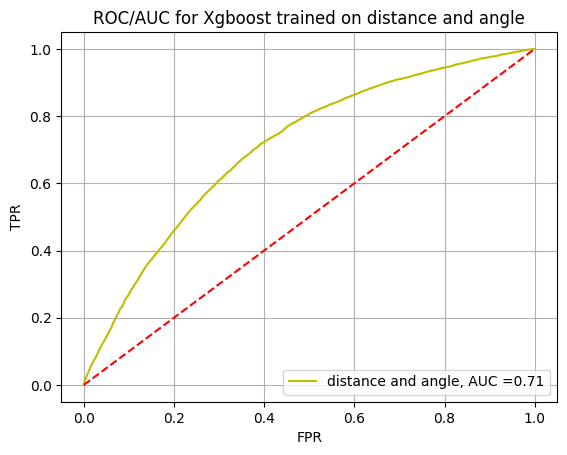

In [7]:
xgboost1=load(xgboost1_path)
val_res = xgboost1.predict_proba(val_X_1)
fpr,tpr,threshold = roc_auc_plot(val_Y,val_res,'Xgboost','distance and angle')

##### Goal rate

In [8]:
probas_and_label = helper_df(val_Y,val_res)
probas_and_label

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
105106,0,0.652118,1,0.0,0.000000,99.996202,1.236050e+06,0.000000e+00,0.000000
228726,1,0.652118,2,0.0,0.000000,99.996202,1.236050e+06,0.000000e+00,0.000000
136051,1,0.652118,3,1.0,33.333333,99.996202,1.236050e+06,3.333333e+01,0.002697
251807,0,0.652118,4,2.0,50.000000,99.996202,1.236050e+06,8.333333e+01,0.006742
27631,0,0.652118,5,2.0,40.000000,99.996202,1.236050e+06,1.233333e+02,0.009978
...,...,...,...,...,...,...,...,...,...
322932,0,0.002019,78983,7447.0,9.428611,0.007596,1.236050e+06,1.236012e+06,99.996949
16437,0,0.001834,78984,7447.0,9.428492,0.003165,1.236050e+06,1.236022e+06,99.997712
258806,0,0.001834,78985,7447.0,9.428372,0.003165,1.236050e+06,1.236031e+06,99.998474
289015,0,0.001834,78986,7447.0,9.428253,0.003165,1.236050e+06,1.236041e+06,99.999237


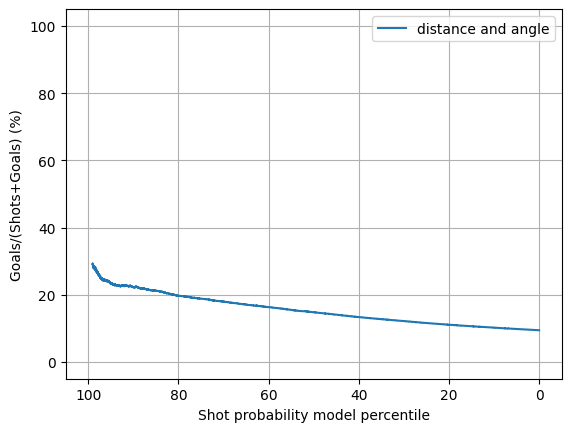

In [13]:
start_length = int(len(probas_and_label)*0.01)
plt.plot(probas_and_label['rank'].iloc[start_length:],probas_and_label['#goal/#goal+#shot'].iloc[start_length:],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

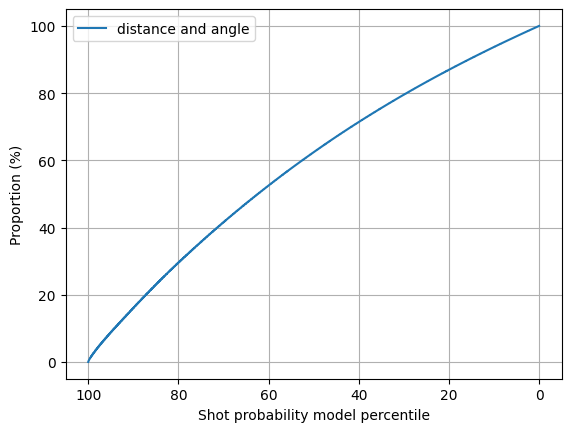

In [10]:
plt.plot(probas_and_label['rank'],probas_and_label['cum_percent'],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

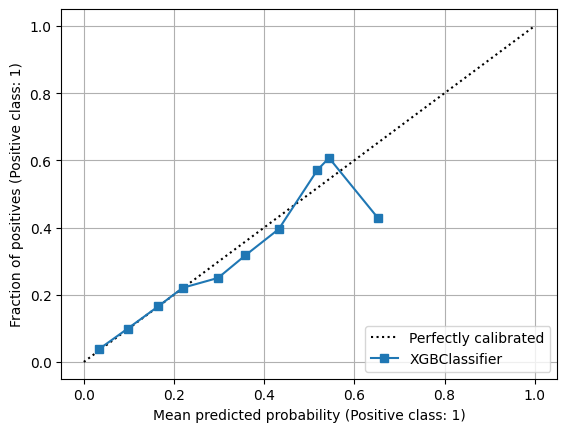

In [11]:
disp = CalibrationDisplay.from_estimator(xgboost1,val_X_1,val_Y,n_bins=15)
plt.grid(True)